In [148]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [149]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from torch.nn import functional as F
import os
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score

In [150]:
device = torch.device("cuda" if torch.cuda.is_available else 'cpu')

In [151]:
device

device(type='cuda')

In [152]:
data = pd.read_csv("/content/drive/MyDrive/captions/captions.txt")

In [153]:
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [154]:
data.shape

(40455, 2)

In [155]:
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

In [156]:
class Vocabulary:
    def __init__(self, tokenizer):
        self.index_to_token = {0: "<unk>",
                               1: "<pad>",
                               2:"<sos>",
                               3:"<eos>"}

        self.token_to_index = {"<unk>": 0,
                               "<pad>": 1,
                               "<sos>": 2,
                               "<eos>": 3}

        self.tokenizer = tokenizer

    def add_token(self, token):
        n = len(self.index_to_token)
        if self.token_to_index.get(token) is None:
            self.token_to_index[token] = n
            self.index_to_token[n] = token

    def get_token(self, index):
        return self.index_to_token[index]

    def get_index(self, token):
        if token not in self.token_to_index.keys():
            return self.token_to_index["<unk>"]
        else:
            return self.token_to_index[token]

    def get_sequence(self, sequence):
        tokens = tokenizer(sequence)
        # print(tokens)
        # n = len(tokens)
        # tokenized_sequence = np.ones(self.max_len)
        tokenized_sequence = [self.get_index("<sos>")]
        tokenized_sequence += [self.get_index(token) for token in tokens]
        tokenized_sequence += [self.get_index("<eos>")]
        return tokenized_sequence

    @staticmethod
    def padd_sequence(sequence, max_len):
        n = len(sequence)
        padded_sequence = np.ones(max_len)
        padded_sequence[-n:] = sequence
        return padded_sequence

    def create_vocabulary(self, df):
        for i, row in df.iterrows():
            tokens = tokenizer(row.caption)
            for token in tokens:
                self.add_token(token)

In [157]:
vocabulary = Vocabulary(tokenizer=tokenizer)

In [158]:
vocabulary.create_vocabulary(data)

In [159]:
NUM_WORDS = len(vocabulary.index_to_token)

In [160]:
NUM_WORDS

8915

In [161]:
vocabulary.get_sequence("I love english.")

[2, 3530, 5202, 6432, 18, 3]

### Show captions

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption: A girl going into a wooden building .
Caption: A little girl climbing into a wooden playhouse .
Caption: A little girl climbing the stairs to her playhouse .
Caption: A little girl in a pink dress going into a wooden cabin .


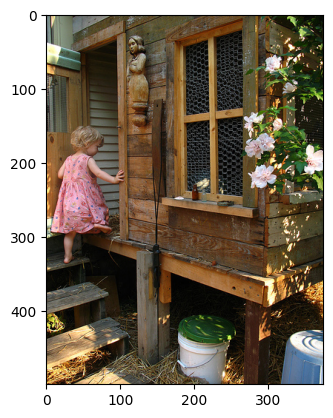

In [162]:
image_dir = "/content/drive/MyDrive/Images"
idx = 0
image_path = os.path.join(image_dir, data.iloc[idx]['image'])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
for i in range(idx, idx+5):
    print("Caption:",data.iloc[i]["caption"])

### Use just part of the dataset

In [163]:
size_small = 10000

data_small = data[:size_small]


In [164]:
len(data_small)

10000

In [165]:
def create_input_sequences(data):
    input_sequences = []


    for i, row in data.iterrows():
        tokenized_sequence = vocabulary.get_sequence(row.caption)


        padded_n_gram_sequence = vocabulary.padd_sequence(tokenized_sequence, MAX_LEN)
        #create line (image_file, caption_sequence)
        input_sequences.append((row.image, padded_n_gram_sequence))

    return input_sequences

In [166]:
def get_max_length(data):
  max_len = 0
  for i, row in data.iterrows():
        tokenized_sequence = vocabulary.get_sequence(row.caption)
        if len(tokenized_sequence)>max_len:
          max_len = len(tokenized_sequence)


  return max_len

In [167]:
MAX_LEN = get_max_length(data_small)

In [168]:
MAX_LEN

40

In [169]:
train_size = int(len(data_small)*0.8)
val_size = len(data_small)-train_size
train_data = data_small[:train_size].reset_index(drop=True)
val_data = data_small[-val_size:].reset_index(drop=True)

In [170]:
len(train_data)

8000

In [171]:
len(val_data)

2000

In [172]:
train_sequences = create_input_sequences(train_data)

In [173]:
len(train_sequences)

8000

In [174]:
val_sequences = create_input_sequences(val_data)

In [175]:
len(val_sequences)

2000

### Flickr dataset

In [176]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self, root_dir, input_sequences, transform=None, max_len=MAX_LEN):
        self.root_dir = root_dir
        self.sequences = input_sequences
        self.transform = transform
        self.max_len = max_len




    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,idx):
        #for caption we take everything except the last word
        caption = self.sequences[idx][1]
        caption = torch.tensor(caption, dtype=torch.int)


        img_name = self.sequences[idx][0]

        img_location = os.path.join(self.root_dir, img_name)
        # img = cv2.imread(img_location)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.open(img_location).convert("RGB")


        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)



        return img, caption

### Check path to images

In [ ]:
for image_name, sequence in train_sequences:
    if not os.path.exists(os.path.join(image_dir, image_name)):
      print(image_dir)

In [ ]:
for image_name, sequence in val_sequences:
    if not os.path.exists(os.path.join(image_dir, image_name)):
      print(image_dir)

In [177]:
#defing the transform to be applied
transforms = T.Compose([
    T.Resize(256),                          # smaller edge of image resized to 256
    T.RandomCrop(224),                      # get 224x224 crop from random location
    T.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    T.ToTensor(),                           # convert the PIL Image to a tensor
    T.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                (0.229, 0.224, 0.225))])

In [178]:
train_dataset =  FlickrDataset(
    root_dir = image_dir,
    input_sequences=train_sequences,
    transform=transforms
)

In [179]:
val_dataset =  FlickrDataset(
    root_dir = image_dir,
    input_sequences=val_sequences,
    transform=transforms
)

In [180]:
train_sequences

[('1000268201_693b08cb0e.jpg',
  array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  4.,  5.,  6.,  4.,  7.,
          8.,  9., 10., 11.,  4., 12., 13., 14.,  6., 15., 16., 17., 18.,
          3.])),
 ('1000268201_693b08cb0e.jpg',
  array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  2.,  4., 19., 20., 21.,  4., 22., 23., 18.,
          3.])),
 ('1000268201_693b08cb0e.jpg',
  array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  2.,  4., 24., 19., 10., 21.,  4., 22., 25., 18.,
          3.])),
 ('1000268201_693b08cb0e.jpg',
  array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1

In [181]:
len(train_dataset)

8000

In [182]:
len(val_dataset)

2000

In [183]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [41]:
images, captions = next(iter(train_loader))

In [ ]:
images

tensor([[[[-1.5699, -1.5699, -1.5528,  ..., -1.6555, -1.6555, -1.6727],
          [-1.5699, -1.5699, -1.5528,  ..., -1.6384, -1.6384, -1.6555],
          [-1.5528, -1.5528, -1.5357,  ..., -1.6213, -1.6384, -1.6555],
          ...,
          [-1.5357, -1.5357, -1.5357,  ..., -1.8097, -1.8268, -1.8439],
          [-1.5528, -1.5528, -1.5528,  ..., -1.8097, -1.8097, -1.7925],
          [-1.5699, -1.5699, -1.5699,  ..., -1.8953, -1.8782, -1.8782]],

         [[-1.4930, -1.4930, -1.4755,  ..., -1.5630, -1.5630, -1.5805],
          [-1.4930, -1.4930, -1.4755,  ..., -1.5455, -1.5455, -1.5630],
          [-1.4755, -1.4755, -1.4580,  ..., -1.5280, -1.5455, -1.5630],
          ...,
          [-1.4230, -1.4230, -1.4230,  ..., -1.9482, -1.9307, -1.9307],
          [-1.4405, -1.4405, -1.4405,  ..., -1.9307, -1.9132, -1.8957],
          [-1.4580, -1.4580, -1.4580,  ..., -1.9657, -1.9307, -1.9307]],

         [[-1.2990, -1.2990, -1.2816,  ..., -1.2990, -1.2990, -1.3164],
          [-1.2990, -1.2990, -

In [ ]:
captions

tensor([[   1,    1,    1,  ...,   26,  360,    3],
        [   1,    1,    1,  ...,  199,   18,    3],
        [   1,    1,    1,  ...,    4,  404,    3],
        ...,
        [   1,    1,    1,  ..., 1138,   18,    3],
        [   1,    1,    1,  ...,   98,   18,    3],
        [   1,    1,    1,  ...,   27,  353,    3]], dtype=torch.int32)

In [ ]:
caption = captions[0]
[vocabulary.get_token(idx.item()) for idx in caption][-15:]

['<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<sos>',
 'a',
 'man',
 'in',
 'an',
 'orange',
 'hat']

In [184]:
class EncoderCNN(nn.Module):
    """Encoder inputs images and returns feature maps.
    Aruments:
    ---------
    - image - augmented image sample

    Returns:
    ---------
    - features - feature maps of size (batch, height*width, #feature maps)
    """
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)
        # first, we need to resize the tensor to be
        # (batch, size*size, feature_maps)
        batch, feature_maps, size_1, size_2 = features.size()
        features = features.permute(0, 2, 3, 1)
        features = features.view(batch, size_1*size_2, feature_maps)

        return features

In [185]:
class BahdanauAttention(nn.Module):
    """ Class performs Additive Bahdanau Attention.
        Source: https://arxiv.org/pdf/1409.0473.pdf

    """
    def __init__(self, num_features, hidden_dim, output_dim = 1):
        super(BahdanauAttention, self).__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        # fully-connected layer to learn first weight matrix Wa
        self.W_a = nn.Linear(self.num_features, self.hidden_dim)
        # fully-connected layer to learn the second weight matrix Ua
        self.U_a = nn.Linear(self.hidden_dim, self.hidden_dim)
        # fully-connected layer to produce score (output), learning weight matrix va
        self.v_a = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, features, decoder_hidden):
        """
        Arguments:
        ----------
        - features - features returned from Encoder
        - decoder_hidden - hidden state output from Decoder

        Returns:
        ---------
        - context - context vector with a size of (1,2048)
        - atten_weight - probabilities, express the feature relevance
        """
        # add additional dimension to a hidden (required for summation)
        decoder_hidden = decoder_hidden.unsqueeze(1)
        atten_1 = self.W_a(features)
        atten_2 = self.U_a(decoder_hidden)
        # apply tangent to combine result from 2 fc layers
        atten_tan = torch.tanh(atten_1+atten_2)
        atten_score = self.v_a(atten_tan)
        atten_weight = F.softmax(atten_score, dim = 1)
        # first, we will multiply each vector by its softmax score
        # next, we will sum up this vectors, producing the attention context vector
        # the size of context equals to a number of feature maps
        context = torch.sum(atten_weight * features,  dim = 1)
        atten_weight = atten_weight.squeeze(dim=2)

        return context, atten_weight

In [186]:
class DecoderRNN(nn.Module):

    """Attributes:
         - embedding_dim - specified size of embeddings;
         - hidden_dim - the size of RNN layer (number of hidden states)
         - vocab_size - size of vocabulary
         - p - dropout probability
    """


    def __init__(self, num_features, embedding_dim, hidden_dim, vocab_size, p =0.5):

        super(DecoderRNN, self).__init__()

        self.num_features = num_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        # scale the inputs to softmax
        self.sample_temp = 0.5

        # embedding layer that turns words into a vector of a specified size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTM will have a single layer of size 512 (512 hidden units)
        # it will input concatinated context vector (produced by attention)
        # and corresponding hidden state of Decoder
        self.lstm = nn.LSTMCell(embedding_dim + num_features, hidden_dim)
        # produce the final output
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # add attention layer
        self.attention = BahdanauAttention(num_features, hidden_dim)
        # dropout layer
        self.drop = nn.Dropout(p=p)
        # add initialization fully-connected layers
        # initialize hidden state and cell memory using average feature vector
        # Source: https://arxiv.org/pdf/1502.03044.pdf
        self.init_h = nn.Linear(num_features, hidden_dim)
        self.init_c = nn.Linear(num_features, hidden_dim)


    def forward(self, captions, features, sample_prob = 0.0):

        """
         Arguments
         ----------
         - captions - image captions
         - features - features returned from Encoder
         - sample_prob - use it for scheduled sampling

         Returns
         ----------
         - outputs - output logits from t steps
         - atten_weights - weights from attention network
         """

        # create embeddings for captions of size (batch, sqe_len, embed_dim)
        embed = self.embeddings(captions)
        h, c = self.init_hidden(features)
        seq_len = captions.size(1)
        feature_size = features.size(1)
        batch_size = features.size(0)

        # these tensors will store the outputs from lstm cell and attention weights
        outputs = torch.zeros(batch_size, seq_len, self.vocab_size)
        atten_weights = torch.zeros(batch_size, seq_len, feature_size)


        # iterate through all words of sequence
        for t in range(seq_len):
            word_embed = embed[:,t,:]
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + hidden_dim)
            input_concat = torch.cat([word_embed, context], 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            outputs[:, t, :] = output
            atten_weights[:, t, :] = atten_weight

        return outputs, atten_weights

    def init_hidden(self, features):

        """Initializes hidden state and cell memory using average feature vector.
        Arguments:
        ----------
        - features - features returned from Encoder

        Retruns:
        ----------
        - h0 - initial hidden state (short-term memory)
        - c0 - initial cell state (long-term memory)
        """
        mean_annotations = torch.mean(features, dim = 1)
        h0 = self.init_h(mean_annotations)
        c0 = self.init_c(mean_annotations)
        return h0, c0

    def greedy_search(self, features, max_sentence = 20):

        """Greedy search to sample top candidate from distribution.
        Arguments
        ----------
        - features - features returned from Encoder
        - max_sentence - max number of token per caption (default=20)

        Returns:
        ----------
        - sentence - list of tokens
        """

        sentence = []
        weights = []
        input_word = torch.tensor(2).unsqueeze(0) #<sos>
        h, c = self.init_hidden(features)
        while True:
            embedded_word = self.embeddings(input_word)
            context, atten_weight = self.attention(features, h)
            # input_concat shape at time step t = (batch, embedding_dim + context size)
            input_concat = torch.cat([embedded_word, context],  dim = 1)
            h, c = self.lstm(input_concat, (h,c))
            h = self.drop(h)
            output = self.fc(h)
            scoring = F.log_softmax(output, dim=1)
            top_idx = scoring[0].topk(1)[1]
            sentence.append(top_idx.item())
            weights.append(atten_weight)
            input_word = top_idx
            if (len(sentence) >= max_sentence or top_idx == 3): #<eos>
                break
        return sentence, weights

In [187]:
def train(encoder,
          decoder,
          optimizer,
          criterion, num_epochs, train_loader, val_loader):
    """ Train function for a single epoch.
    Arguments:
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder
    - decoder - model's Decoder
    - optimizer - model's optimizer (Adam in our case)
    - criterion - loss function to optimize
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the training logs

    """
    min_loss = 10

    for epoch in range(num_epochs):

        epoch_loss = 0.0
        epoch_perplex = 0.0

        # training mode on
        encoder.eval() # no fine-tuning for Encoder
        decoder.train()

        total_step=0
        # Obtain the batch.
        for images, captions in train_loader:
          images = images.to(device)
          # target captions, excluding the first word
          captions_target = captions[:, 1:].to(device)
          # captions for training without the last word
          captions_train = captions[:, :-1].to(device)

          captions_target = torch.tensor(captions_target, dtype=torch.long)


          # Zero the gradients.
          decoder.zero_grad()
          encoder.zero_grad()

          # Pass the inputs through the CNN-RNN model.
          features = encoder(images)
          outputs, atten_weights = decoder(captions= captions_train,
                                          features = features)

          outputs = outputs.to(device)



          # Calculate the batch loss.
          loss = criterion(outputs.view(-1, vocab_size), captions_target.reshape(-1))

          # Backward pass.
          loss.backward()

          # Update the parameters in the optimizer.
          optimizer.step()

          perplex = np.exp(loss.item())
          epoch_loss += loss.item()
          epoch_perplex += perplex

          total_step+=1

        epoch_loss_avg = epoch_loss / total_step
        epoch_perp_avg = epoch_perplex / total_step

        print('\r')
        print('Epoch train:', epoch)
        print('\r' + 'Avg. Loss train: %.4f, Avg. Perplexity train: %5.4f' % (epoch_loss_avg, epoch_perp_avg), end="")
        print('\r')

        val_loss_avg = validate(epoch, encoder, decoder, optimizer, criterion, val_loader)

        # Save the weights.
        if val_loss_avg < min_loss:
          min_loss = val_loss_avg
          torch.save(decoder.state_dict(), os.path.join('/content/drive/MyDrive/ImageCaptioningModels/', 'decoder.pkl'))
          torch.save(encoder.state_dict(), os.path.join('/content/drive/MyDrive/ImageCaptioningModels/', 'encoder.pkl'))


In [188]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

In [189]:
references = [["i", "love", "english", "language"]]
hypothesis = ["i", "love", "english"]
sentence_bleu(references, hypothesis, weights = (1.0, 0, 0, 0))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


0.7165313105737893

In [71]:
import nltk
hypothesis = ['This', 'is', 'cat']
reference = ['This', 'is', 'a', 'cat']
references = [reference] # list of references for 1 sentence.
list_of_references = [reference] # list of references for all sentences in corpus.
list_of_hypotheses = [hypothesis] # list of hypotheses that corresponds to list of references.
nltk.translate.bleu_score.corpus_bleu(list_of_references, list_of_hypotheses)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

0.141080287481769

In [82]:
from nltk.translate.bleu_score import corpus_bleu

references = [[['my', 'first', 'correct', 'sentence']],[['i', 'love', 'english']]]
candidates = [['my', 'first', 'correct','sentence'],['i','love','english']]
score = corpus_bleu(references, candidates)
score

0.8408964152537145

In [66]:
nltk.translate.bleu_score.sentence_bleu(references, hypothesis, weights=(1, 0, 0, 0))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


0.7165313105737893

In [190]:
def compute_bleu_score(outputs, targets):
  #get predicted caption by words
  softmax = nn.Softmax(dim=-1)
  bleu_score = 0
  for output, target in zip(outputs, targets):
    probabilities = softmax(output)
    indexes = probabilities.argmax(dim=-1)
    hypothesis = [vocabulary.get_token(index.item()) for index in indexes]
    reference = [vocabulary.get_token(index.item()) for index in target]
    bleu_score += sentence_bleu(reference, hypothesis, weights=(1,0,0,0))

  bleu_1 = bleu_score/len(outputs)

  return bleu_1

In [191]:
def validate(epoch,
             encoder,
             decoder,
             optimizer,
             criterion,
             data_loader):
    """ Validation function for a single epoch.
    Arguments:
    ----------
    - epoch - number of current epoch
    - encoder - model's Encoder (evaluation)
    - decoder - model's Decoder (evaluation)
    - optimizer - model's optimizer (Adam in our case)
    - criterion - optimized loss function
    - num_epochs - total number of epochs
    - data_loader - specified data loader (for training, validation or test)
    - write_file - file to write the validation logs
    """
    epoch_loss = 0.0
    epoch_perplex = 0.0

    # evaluation of encoder and decoder
    encoder.eval()
    decoder.eval()

    total_step = 0
    total_bleu = 0

    for val_images, val_captions in data_loader:

        val_captions_target = val_captions[:, 1:].to(device)
        val_captions = val_captions[:, :-1].to(device)
        val_images = val_images.to(device)

        val_captions_target = torch.tensor(val_captions_target, dtype=torch.long)

        features_val = encoder(val_images)
        outputs_val, atten_weights_val = decoder(captions= val_captions,
                                         features = features_val)

        outputs_val = outputs_val.to(device)

        loss_val = criterion(outputs_val.view(-1, vocab_size),
                             val_captions_target.reshape(-1))


        perplex = np.exp(loss_val.item())
        epoch_loss += loss_val.item()
        epoch_perplex += perplex

        total_step+=1

        bleu_score = compute_bleu_score(outputs_val, val_captions_target)
        total_bleu += bleu_score

    epoch_loss_avg = epoch_loss / total_step
    epoch_perp_avg = epoch_perplex / total_step
    bleu_avg = total_bleu/total_step

    print('\r')
    print('Epoch valid:', epoch)
    print('Avg. Loss valid: %.4f, Avg. Perplexity valid: %5.4f' % (epoch_loss_avg, epoch_perp_avg))
    print('Avg bleu score: %.4f' % bleu_avg)

    return epoch_loss_avg



In [192]:
vocab_size = NUM_WORDS
embed_size = 256         # dimensionality of image and word embeddings
hidden_size = 512        # number of features in hidden state of the RNN decoder
num_features = 2048      # number of feature maps, produced by Encoder
num_epochs = 20          # number of training epochs
save_every = 1           # determines frequency of saving model weights

In [193]:
encoder = EncoderCNN()
decoder = DecoderRNN(num_features, embed_size, hidden_size, vocab_size)
encoder.to(device)
decoder.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DecoderRNN(
  (embeddings): Embedding(8915, 256)
  (lstm): LSTMCell(2304, 512)
  (fc): Linear(in_features=512, out_features=8915, bias=True)
  (attention): BahdanauAttention(
    (W_a): Linear(in_features=2048, out_features=512, bias=True)
    (U_a): Linear(in_features=512, out_features=512, bias=True)
    (v_a): Linear(in_features=512, out_features=1, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
)

In [194]:
learning_rate = 1e-4

loss_fn = nn.CrossEntropyLoss(ignore_index=vocabulary.get_index("<pad>")).cuda()
optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

In [195]:
train(encoder,
      decoder,
      optimizer,
      loss_fn, num_epochs, train_loader, val_loader)

<ipython-input-187-45f72fed0c9c>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions_target = torch.tensor(captions_target, dtype=torch.long)



Epoch train: 0
Avg. Loss train: 5.2141, Avg. Perplexity train: 530.2407


<ipython-input-191-63defe6997c3>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_captions_target = torch.tensor(val_captions_target, dtype=torch.long)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Epoch valid: 0
Avg. Loss valid: 4.3776, Avg. Perplexity valid: 80.3009
Avg bleu score: 0.0497

Epoch train: 1
Avg. Loss train: 4.1661, Avg. Perplexity train: 65.4282

Epoch valid: 1
Avg. Loss valid: 4.0539, Avg. Perplexity valid: 58.2228
Avg bleu score: 0.0509

Epoch train: 2
Avg. Loss train: 3.8649, Avg. Perplexity train: 48.2160

Epoch valid: 2
Avg. Loss valid: 3.8508, Avg. Perplexity valid: 47.9637
Avg bleu score: 0.0514

Epoch train: 3
Avg. Loss train: 3.6590, Avg. Perplexity train: 39.3340

Epoch valid: 3
Avg. Loss valid: 3.7093, Avg. Perplexity valid: 41.4711
Avg bleu score: 0.0513

Epoch train: 4
Avg. Loss train: 3.4998, Avg. Perplexity train: 33.4559

Epoch valid: 4
Avg. Loss valid: 3.6060, Avg. Perplexity valid: 37.4785
Avg bleu score: 0.0507

Epoch train: 5
Avg. Loss train: 3.3739, Avg. Perplexity train: 29.4762

Epoch valid: 5
Avg. Loss valid: 3.5144, Avg. Perplexity valid: 34.0616
Avg bleu score: 0.0517

Epoch train: 6
Avg. Loss train: 3.2674, Avg. Perplexity train: 26.568


### Load model


In [210]:
import pickle
encoder.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningModels/encoder.pkl'))
decoder.load_state_dict(torch.load('/content/drive/MyDrive/ImageCaptioningModels/decoder.pkl'))

encoder.to('cpu')
decoder.to('cpu')

encoder.eval()
decoder.eval()

DecoderRNN(
  (embeddings): Embedding(8915, 256)
  (lstm): LSTMCell(2304, 512)
  (fc): Linear(in_features=512, out_features=8915, bias=True)
  (attention): BahdanauAttention(
    (W_a): Linear(in_features=2048, out_features=512, bias=True)
    (U_a): Linear(in_features=512, out_features=512, bias=True)
    (v_a): Linear(in_features=512, out_features=1, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
)

### Generate captions

In [204]:
image =  Image.open("/content/drive/MyDrive/Images/1001773457_577c3a7d70.jpg").convert("RGB")

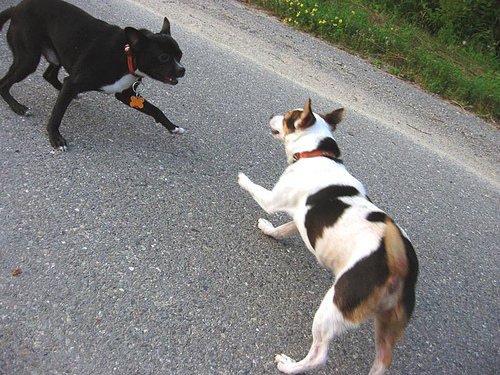

In [205]:
image

In [206]:
def preprocess_image(image):
    image = transforms(image)
    return image

In [207]:
def encode_caption(caption):
  tokens = tokenizer(caption)

  tokenized_sequence = [vocabulary.get_index(token) for token in tokens]

  return tokenized_sequence

In [208]:
def generate_caption(image, encoder, decoder):
    image = preprocess_image(image)

    image.unsqueeze_(0)

    #next_word=caption=<sos>
    next_word = '<sos>'
    caption = next_word


    while next_word != '<eos>':
        encoded_caption = encode_caption(caption)
        encoded_caption = torch.tensor(encoded_caption, dtype=torch.int)
        encoded_caption.unsqueeze_(dim=0)
        print(encoded_caption)

        features = encoder(image)
        outputs, atten_weights = decoder(captions= encoded_caption,
                                          features = features)

        print(outputs.shape)

        softmax = nn.Softmax(dim=-1)
        probabilities = softmax(outputs[:,-1])
        index = probabilities.argmax(dim=-1)
        next_word = vocabulary.get_token(index.item())

        caption = caption+" "+next_word

    return caption

In [211]:
captions = generate_caption(image, encoder, decoder)

tensor([[2]], dtype=torch.int32)
torch.Size([1, 1, 8915])
tensor([[2, 2]], dtype=torch.int32)
torch.Size([1, 2, 8915])
tensor([[2, 2, 4]], dtype=torch.int32)
torch.Size([1, 3, 8915])
tensor([[ 2,  2,  4, 30]], dtype=torch.int32)
torch.Size([1, 4, 8915])
tensor([[ 2,  2,  4, 30, 32]], dtype=torch.int32)
torch.Size([1, 5, 8915])
tensor([[ 2,  2,  4, 30, 32, 43]], dtype=torch.int32)
torch.Size([1, 6, 8915])
tensor([[ 2,  2,  4, 30, 32, 43, 31]], dtype=torch.int32)
torch.Size([1, 7, 8915])
tensor([[ 2,  2,  4, 30, 32, 43, 31,  9]], dtype=torch.int32)
torch.Size([1, 8, 8915])
tensor([[  2,   2,   4,  30,  32,  43,  31,   9, 121]], dtype=torch.int32)
torch.Size([1, 9, 8915])
tensor([[  2,   2,   4,  30,  32,  43,  31,   9, 121,   6]], dtype=torch.int32)
torch.Size([1, 10, 8915])
tensor([[  2,   2,   4,  30,  32,  43,  31,   9, 121,   6,  26]],
       dtype=torch.int32)
torch.Size([1, 11, 8915])
tensor([[  2,   2,   4,  30,  32,  43,  31,   9, 121,   6,  26, 231]],
       dtype=torch.int32)
t

In [212]:
print(captions)

<sos> <sos> a black and white dog is running in the air with a red and white dog is running on a path with a red ball . <eos>


In [213]:
image = preprocess_image(image)
image.unsqueeze_(0)
features = encoder(image)

# Pass the embedded image features through the model to get a predicted caption.
output, atten_weights = decoder.greedy_search(features)
print('example output:', output)

example output: [2, 4, 30, 32, 43, 31, 9, 121, 41, 4, 113, 32, 43, 31, 9, 121, 41, 4, 113, 32]


In [214]:
print([vocabulary.get_token(token) for token in output])

['<sos>', 'a', 'black', 'and', 'white', 'dog', 'is', 'running', 'on', 'a', 'red', 'and', 'white', 'dog', 'is', 'running', 'on', 'a', 'red', 'and']
